In [43]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, Conv2D, GlobalMaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model

In [44]:
class GAN(keras.Model):
  def __init__(self):
    super(GAN, self).__init__()
    self.latent_dim = 128
    self.generator = self.build_gen()
    self.discriminator = self.build_disc()

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  def train_step(self, real):
    batch_size = tf.shape(real)[0]
    noise = tf.random.normal([batch_size, self.latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = self.generator(noise, training=True)
      
      real_output = self.discriminator(real, training=True)
      fake_output = self.discriminator(generated_images, training=True)

      d_loss = self.loss_fn(tf.ones_like(real_output), real_output) + self.loss_fn(tf.zeros_like(fake_output), fake_output)
      g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

    gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_weights)
    gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_weights)

    self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_weights))
    self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_weights))
    
    return {"d_loss": d_loss, "g_loss": g_loss}

  def plot_images(self):
    seed = tf.random.normal([4, 128])
    predictions = self.generator(seed, training=False)
    print(type(predictions))

    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
      plt.subplot(1, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255.0, cmap="gray")
      plt.axis("off")
    plt.show()

  def build_disc(self):
    # inputs = keras.Input(shape=(self.latent_dim,))
    # x = Dense(128)(inputs)
    # x = LeakyReLU(alpha=0.2)(x)
    # x = Dense(256)(x)
    # x = LeakyReLU(alpha=0.2)(x)
    # x = Dense(28*28*1, activation="tanh")(x)
    # outputs = Reshape((28,28,1))(x)
    # model = Model(inputs=inputs, outputs=outputs)
    # return model
    discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        LeakyReLU(alpha=0.2),
        GlobalMaxPooling2D(),
        Dense(1),
    ],
      name="discriminator",
    )
    return discriminator

  
  def build_gen(self):
    # inputs = keras.Input(shape=(28,28,1))
    # x = Dense(512)(inputs)
    # x = LeakyReLU(alpha=0.2)(x)
    # x = Dense(256)(x)
    # x = LeakyReLU(alpha=0.2)(x)
    # outputs = Dense(1)(x)
    # model = Model(inputs=inputs, outputs=outputs)
    # return model
    generator = keras.Sequential(
    [
        keras.Input(shape=(128,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        Dense(7 * 7 * 128),
        LeakyReLU(alpha=0.2),
        Reshape((7, 7, 128)),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
      name="generator",
    )
    return generator

In [45]:
import numpy as np
gan = GAN()
(X_train, _), (_, _) = keras.datasets.mnist.load_data()
X_train = X_train.astype("float32") / 255.0
X_train = np.reshape(X_train, (-1, 28,28,1))

In [46]:
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(64)

In [47]:
gan.compile(
  d_optimizer=keras.optimizers.Adam(learning_rate=3e-4),
  g_optimizer=keras.optimizers.Adam(learning_rate=3e-4),
  loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
)

In [48]:
gan.fit(dataset, epochs=20)

Epoch 1/20


2021-12-31 15:36:42.186318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 90s 95ms/step - d_loss: 0.7962 - g_loss: 1.8900
Epoch 2/20
938/938 [==============================] - 89s 95ms/step - d_loss: 0.8246 - g_loss: 1.3605
Epoch 3/20
938/938 [==============================] - 89s 95ms/step - d_loss: 0.8107 - g_loss: 1.5872
Epoch 4/20
938/938 [==============================] - 88s 94ms/step - d_loss: 1.2642 - g_loss: 0.8489
Epoch 5/20
938/938 [==============================] - 90s 96ms/step - d_loss: 1.3166 - g_loss: 0.7988
Epoch 6/20
938/938 [==============================] - 89s 95ms/step - d_loss: 1.2810 - g_loss: 0.8173
Epoch 7/20
938/938 [==============================] - 89s 95ms/step - d_loss: 1.2626 - g_loss: 0.8460
Epoch 8/20
938/938 [==============================] - 90s 95ms/step - d_loss: 1.1833 - g_loss: 0.9459
Epoch 9/20
938/938 [==============================] - 90s 95ms/step - d_loss: 1.2094 - g_loss: 0.8932
Epoch 10/20
938/938 [==============================] - 91s 97ms/step - d_loss: 1.1627 - g_los

<class 'tensorflow.python.framework.ops.EagerTensor'>


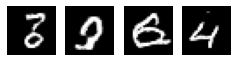

In [49]:
gan.plot_images()

In [50]:
gan.generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 28, 28, 128)       0 

In [51]:
gan.discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 129       
Total params: 74,625
Trainable params: 74,625
Non-trainable params: 0
_________________________________________________